In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("/content/drive/MyDrive/data_multi_pchip_5.csv")

In [ ]:
data

In [ ]:
ndvi_columns = [f"NDVI_{i}" for i in range(1, 101)]  # Adjust this range according to the actual number of your NDVI columns

# Use pandas DataFrame method 'all' twice to check that all values in all specified columns are within the desired range
all_within_range = data[ndvi_columns].apply(lambda x: (0 <= x) & (x <= 1)).all().all()

print("All NDVI values are within the range of 0 to 1:", all_within_range)


All NDVI values are within the range of 0 to 1: True


# 1. Split and normalize the data

In [4]:
# Select columns to rename
dem_columns = [f'DEM {i}' for i in range(1, 101)]

# Rename columns
new_dem_columns = [f'DEM_{i}' for i in range(1, 101)]
data = data.rename(columns=dict(zip(dem_columns, new_dem_columns)))


In [ ]:

# Repeat 'Rainfall' and 'Temperature' across 100 new columns
for i in range(1, 101):
    data[f'Rainfall_{i}'] = data['Rainfall']

for i in range(1, 101):
    data[f'Temperature_{i}'] = data['Temperature']

# Delete the original 'Rainfall' and 'Temperature' columns
data = data.drop(columns=['Rainfall', 'Temperature'])


In [6]:
# Split the data

pixel_ids = data['Pixel_ID'].unique()

# Randomly shuffle the pixel_ids
np.random.shuffle(pixel_ids)

split_idx_1 = int(0.7 * len(pixel_ids))
split_idx_2 = int(0.9 * len(pixel_ids))  # Adjusted for 70% training, 20% validation, 10% test split

train_pixel_ids = pixel_ids[:split_idx_1]
val_pixel_ids = pixel_ids[split_idx_1:split_idx_2]
test_pixel_ids = pixel_ids[split_idx_2:]

train_data = data.loc[data['Pixel_ID'].isin(train_pixel_ids)]
val_data = data.loc[data['Pixel_ID'].isin(val_pixel_ids)]
test_data = data.loc[data['Pixel_ID'].isin(test_pixel_ids)]

In [ ]:
# Normalization

from sklearn.preprocessing import MinMaxScaler

# Scale temperature, rainfall, NDVI, and DEM variables
temp_scalers = [MinMaxScaler() for _ in range(100)]
rain_scalers = [MinMaxScaler() for _ in range(100)]
ndvi_scalers = [MinMaxScaler() for _ in range(100)]
dem_scalers = [MinMaxScaler() for _ in range(100)]  # Assuming there are 100 DEM features

for i in range(1, 101):
    train_data[f'Temperature_{i}_scaled'] = temp_scalers[i - 1].fit_transform(train_data[f'Temperature_{i}'].values.reshape(-1, 1))
    train_data[f'Rainfall_{i}_scaled'] = rain_scalers[i - 1].fit_transform(train_data[f'Rainfall_{i}'].values.reshape(-1, 1))
    train_data[f'NDVI_{i}_scaled'] = ndvi_scalers[i - 1].fit_transform(train_data[f'NDVI_{i}'].values.reshape(-1, 1))
    train_data[f'DEM_{i}_scaled'] = dem_scalers[i - 1].fit_transform(train_data[f'DEM_{i}'].values.reshape(-1, 1))

    # Apply the scaler fitted on the training data to the validation and test data
    val_data[f'Temperature_{i}_scaled'] = temp_scalers[i - 1].transform(val_data[f'Temperature_{i}'].values.reshape(-1, 1))
    val_data[f'Rainfall_{i}_scaled'] = rain_scalers[i - 1].transform(val_data[f'Rainfall_{i}'].values.reshape(-1, 1))
    val_data[f'NDVI_{i}_scaled'] = ndvi_scalers[i - 1].transform(val_data[f'NDVI_{i}'].values.reshape(-1, 1))
    val_data[f'DEM_{i}_scaled'] = dem_scalers[i - 1].transform(val_data[f'DEM_{i}'].values.reshape(-1, 1))

    test_data[f'Temperature_{i}_scaled'] = temp_scalers[i - 1].transform(test_data[f'Temperature_{i}'].values.reshape(-1, 1))
    test_data[f'Rainfall_{i}_scaled'] = rain_scalers[i - 1].transform(test_data[f'Rainfall_{i}'].values.reshape(-1, 1))
    test_data[f'NDVI_{i}_scaled'] = ndvi_scalers[i - 1].transform(test_data[f'NDVI_{i}'].values.reshape(-1, 1))
    test_data[f'DEM_{i}_scaled'] = dem_scalers[i - 1].transform(test_data[f'DEM_{i}'].values.reshape(-1, 1))
 

In [8]:
import re

# Define the regular expression pattern
pattern = re.compile(r'^(Rainfall|Temperature|NDVI|DEM)_[0-9]+(?<!_scaled)$')

# Get the columns to drop for each dataset
cols_to_drop_train = [col for col in train_data.columns if pattern.search(col)]
cols_to_drop_val = [col for col in val_data.columns if pattern.search(col)]
cols_to_drop_test = [col for col in test_data.columns if pattern.search(col)]

# Drop the columns from each dataframe
train_scaled = train_data.drop(cols_to_drop_train, axis=1)
val_scaled = val_data.drop(cols_to_drop_val, axis=1)
test_scaled = test_data.drop(cols_to_drop_test, axis=1)


In [ ]:
test_scaled

In [ ]:
ndvi_columns = [f"NDVI_{i}_scaled" for i in range(1, 101)]  # Adjust this range according to the actual number of your NDVI columns

# Use pandas DataFrame method 'all' twice to check that all values in all specified columns are within the desired range
all_within_range = test_scaled[ndvi_columns].apply(lambda x: (0 <= x) & (x <= 1)).all().all()

print("All NDVI values are within the range of 0 to 1:", all_within_range)

All NDVI values are within the range of 0 to 1: False


In [ ]:
# Check for NaN values in the scaled input features
has_nan = train_scaled.isna().any().any()
print("NaN values in the scaled input features:", has_nan)

NaN values in the scaled input features: False


# 2. Build data structure for train the model

In [ ]:
pip install tensorflow

In [9]:
# Import necessary libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation, Flatten
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, TimeDistributed
from tensorflow.keras.layers import Conv1D, Conv2D, ConvLSTM2D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D, AveragePooling1D, GlobalMaxPooling1D
 
from tensorflow.keras.regularizers import l1,l2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
import joblib
from keras.models import load_model
import time
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import layers, Model


In [10]:
# Select input and output variables
input_vars = [f'NDVI_{i}_scaled' for i in range(1, 101)] + [f'Rainfall_{i}_scaled' for i in range(1, 101)] + [f'Temperature_{i}_scaled' for i in range(1, 101)] + [f'DEM_{i}_scaled' for i in range(1, 101)]
output_vars = [f'NDVI_{i}_scaled' for i in range(1, 101)]

# Define window size for input sequences
window_size = 20

# Create sequences of input and output for training data
X_train = []
y_train = []
for pixel_id in train_scaled['Pixel_ID'].unique():
    pixel_data = train_scaled[train_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_train.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_train.append(pixel_data.loc[i, output_vars].values)

# Create sequences of input and output for validation data
X_val = []
y_val = []
for pixel_id in val_scaled['Pixel_ID'].unique():
    pixel_data = val_scaled[val_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_val.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_val.append(pixel_data.loc[i, output_vars].values)

# Create sequences of input and output for testing data
X_test = []
y_test = []
for pixel_id in test_scaled['Pixel_ID'].unique():
    pixel_data = test_scaled[test_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_test.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_test.append(pixel_data.loc[i, output_vars].values)


In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# # save with numpy
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [ ]:
# X_train = np.load('X_train.npy', allow_pickle=True)
# y_train = np.load('y_train.npy', allow_pickle=True)
# X_val = np.load('X_val.npy', allow_pickle=True)
# y_val = np.load('y_val.npy', allow_pickle=True)
# X_test = np.load('X_test.npy', allow_pickle=True)
# y_test = np.load('y_test.npy', allow_pickle=True)



In [12]:
X_test.shape

(10530, 20, 400)

In [13]:
X_train.shape

(73680, 20, 400)

In [ ]:
# X_test_multi_reshaped = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
# X_test_multi_reshaped.shape

## 2.0 prepare data for convLSTM and transformer model

In [14]:
# Convert lists to numpy arrays
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')
X_val = np.array(X_val).astype('float32')
y_val = np.array(y_val).astype('float32')
X_test = np.array(X_test).astype('float32')
y_test = np.array(y_test).astype('float32')


In [15]:
# Determine the dimensions of the input data
samples_train = X_train.shape[0]
samples_val = X_val.shape[0]
samples_test = X_test.shape[0]
time = X_train.shape[1]
channels = X_train.shape[2]

# Reshape the input data to be suitable for ConvLSTM
X_train = X_train.reshape((samples_train, time, 10, 10, 4))  # 4 for NDVI, DEM, Rainfall, and Temperature
X_val = X_val.reshape((samples_val, time, 10, 10, 4))
X_test = X_test.reshape((samples_test, time, 10, 10, 4))

In [16]:
# # Reshape y_train, y_val, and y_test
y_train = tf.reshape(y_train, (-1, 10, 10, 1))
y_val = tf.reshape(y_val, (-1, 10, 10, 1))
y_test = tf.reshape(y_test, (-1, 10, 10, 1)) 

In [17]:
print("X_train shape:", np.shape(X_train))
print("X_val shape:", np.shape(X_val))
print("X_test shape:", np.shape(X_test))
print("y_train shape:", np.shape(y_train))
print("y_val shape:", np.shape(y_val))
print("y_test shape:", np.shape(y_test))

X_train shape: (73680, 20, 10, 10, 4)
X_val shape: (21050, 20, 10, 10, 4)
X_test shape: (10530, 20, 10, 10, 4)
y_train shape: (73680, 10, 10, 1)
y_val shape: (21050, 10, 10, 1)
y_test shape: (10530, 10, 10, 1)


In [ ]:
y_test_reshaped = np.reshape(y_test, (y_test.shape[0], -1))
y_val_reshaped = np.reshape(y_val, (y_val.shape[0], -1))

print(np.array(y_test_reshaped).shape)
print(np.array(y_val_reshaped).shape)

(10530, 100)
(21050, 100)


In [ ]:
y_test_reshaped_df = pd.DataFrame(y_test_reshaped)


In [ ]:
# Use pandas DataFrame method 'all' twice to check that all values in all specified columns are within the desired range
all_within_range = y_test_reshaped_df.apply(lambda x: (0 <= x) & (x <= 1)).all().all()

print("All NDVI values are within the range of 0 to 1:", all_within_range)

All NDVI values are within the range of 0 to 1: True


In [ ]:
# y_test_reshaped_df_c = y_test_reshaped_df.iloc[:, 50].to_frame()
# y_test_reshaped_df_c.columns = ['y_test_NDVI_c']
# y_test_reshaped_df_c

In [ ]:
# Now you can use the describe method
# y_test_reshaped_df_c.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y_test_NDVI_c,20510.0,0.763048,0.117195,0.001801,0.667033,0.775532,0.860765,0.999824


## 2.3 convLSTM

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:

# Define height, width, and number of channels
height = 10
width = 10
num_channels = 4

num_outputs = 1

# Assume a learning rate
learning_rate = 0.0005

# Define the model architecture
with tf.device('/GPU:0'):
    convlstm_model = Sequential()
    convlstm_model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu', 
                                  input_shape=(window_size, height, width, num_channels), 
                                  padding='same', return_sequences=True))
    convlstm_model.add(BatchNormalization())
    convlstm_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', 
                                  padding='same', return_sequences=False))
    convlstm_model.add(BatchNormalization())
    #convlstm_model.add(Flatten())
    convlstm_model.add(Dense(32, activation='relu'))
    convlstm_model.add(BatchNormalization())
    convlstm_model.add(Dense(num_outputs, activation='linear'))

    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    convlstm_model.compile(loss=loss_fn, optimizer=optimizer)

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    convlstm_model.summary()

    start_time_convlstm = time.time()
    convlstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128,callbacks=[early_stop])
    
    end_time_convlstm = time.time()

    print("Training took: ", end_time_convlstm - start_time_convlstm, " seconds")


In [ ]:
convlstm_pred_train = convlstm_model.predict(X_train)
convlstm_pred_val = convlstm_model.predict(X_val)
convlstm_pred_test = convlstm_model.predict(X_test)

330/330 [==============================] - 19s 58ms/step


In [ ]:
# Check the shapes of y_true and y_pred
print(np.array(y_train).shape)
print(np.array(y_val).shape)
print(np.array(y_test).shape)
print(np.array(convlstm_pred_train).shape)
print(np.array(convlstm_pred_val).shape)
print(np.array(convlstm_pred_test).shape)
print(X_train.shape)

(73680, 10, 10, 1)
(21050, 10, 10, 1)
(10530, 10, 10, 1)
(73680, 10, 10, 1)
(21050, 10, 10, 1)
(10530, 10, 10, 1)
(73680, 20, 10, 10, 4)


In [ ]:
# Flatten the predictions
convlstm_pred_test = convlstm_pred_test.reshape(convlstm_pred_test.shape[0], -1)
convlstm_pred_val = convlstm_pred_val.reshape(convlstm_pred_val.shape[0], -1)
y_test_reshaped = np.reshape(y_test, (y_test.shape[0], -1))
y_val_reshaped = np.reshape(y_val, (y_val.shape[0], -1))


print(np.array(convlstm_pred_test).shape)
print(np.array(convlstm_pred_val).shape)
print(np.array(y_test_reshaped).shape)
print(np.array(y_val_reshaped).shape)

(10530, 100)
(21050, 100)
(10530, 100)
(21050, 100)


In [ ]:
convlstm_pred_test_df = pd.DataFrame(convlstm_pred_test)

In [ ]:
# Now you can use the describe method
convlstm_pred_test_df.describe().transpose()

In [ ]:
convlstm_pred_test_df_c = convlstm_pred_test_df.iloc[:, 50].to_frame()
convlstm_pred_test_df_c.columns = ['ConvLSTM_pred_NDVI_c']
convlstm_pred_test_df_c.shape

(10530, 1)

In [ ]:
# Now you can use the describe method
convlstm_pred_test_df_c.describe().transpose()

In [ ]:
# Now compute MSE
convlstm_mse = mean_squared_error(y_test_reshaped, convlstm_pred_test)
print("convLSTM Mean Squared Error:", convlstm_mse)

convLSTM Mean Squared Error: 0.008444431


In [ ]:
# save model
convlstm_model.save("/content/drive/MyDrive/Saved_models/convlstm_model_multi_5")

In [ ]:
# Load convlstm model
convlstm_model = load_model("/content/drive/MyDrive/Saved_models/convlstm_model_multi_2")

## 2.4 Transformer

In [ ]:
import time
# Positional encoding for the transformer model

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head attention
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

# Transformer Encoder Layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = layers.Dense(self.d_model, activation='linear')
        self.pos_encoding = positional_encoding(input_shape[0], self.d_model)
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

def create_simplified_transformer_model(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    conv2d = layers.TimeDistributed(layers.Conv2D(128, (3,3), activation='relu'))(inputs)
    reshaped = layers.Reshape((input_shape[0], -1))(conv2d)
    mask = None
    x = TransformerEncoder(num_layers, d_model, num_heads, dff, (input_shape[0], reshaped.shape[-1]), rate)(reshaped, training=None, mask=mask)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(10*10, activation='linear')(x) # Output layer now has size 10*10
    x = layers.Reshape((10, 10, 1))(x) # Reshape to match your y_true shape
    x = layers.Dense(1)(x) # Add another dense layer
    outputs = layers.Reshape((10, 10, 1))(x) # Reshape to match your y_true shape
    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (20, 10, 10, 4)
num_layers = 2
d_model = 128
num_heads = 2
dff = 256
dropout_rate = 0.01

transformer_model = create_simplified_transformer_model(input_shape, num_layers, d_model, num_heads, dff, dropout_rate)
transformer_model.summary()

transformer_model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005), metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start recording training time
start_time_transformer = time.time()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 10, 10, 4)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 20, 8, 8, 128)    4736      
 ibuted)                                                         
                                                                 
 reshape (Reshape)           (None, 20, 8192)          0         
                                                                 
 transformer_encoder (Transf  (None, 20, 128)          1313664   
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                             

In [ ]:
history = transformer_model.fit(X_train, y_train, epochs=100, batch_size= 64,validation_data=(X_val, y_val),callbacks=[early_stop])


In [ ]:
# Calculate the training time
training_time_transformer = time.time() - start_time_transformer
print("Training time: ", training_time_transformer, "seconds")

Training time:  712.2081468105316 seconds


In [ ]:
transformer_pred_train = transformer_model.predict(X_train)
transformer_pred_val = transformer_model.predict(X_val)
transformer_pred_test = transformer_model.predict(X_test)

330/330 [==============================] - 2s 7ms/step


In [ ]:
# Flatten the predictions
transformer_pred_test = transformer_pred_test.reshape(transformer_pred_test.shape[0], -1)
transformer_pred_val = transformer_pred_val.reshape(transformer_pred_val.shape[0], -1)

print(np.array(transformer_pred_test).shape)
print(np.array(transformer_pred_val).shape)
# print(np.array(y_test_reshaped).shape)

(10530, 100)
(21050, 100)


In [ ]:
# Evaluate the model on the test set
transformer_mse = mean_squared_error(y_test_reshaped, transformer_pred_test)
print("Transformer Mean Squared Error:", transformer_mse)

Transformer Mean Squared Error: 0.005168142


In [ ]:
transformer_pred_test_df = pd.DataFrame(transformer_pred_test)


In [ ]:

transformer_pred_test_df_c = transformer_pred_test_df.iloc[:, 50].to_frame()
transformer_pred_test_df_c.columns = ['Transformer_pred_NDVI_c']


In [ ]:
# Now you can use the describe method
transformer_pred_test_df_c.describe().transpose()

In [ ]:
# save model
transformer_model.save("/content/drive/MyDrive/Saved_models/transformer_model_multi_5")

In [ ]:
# Load transformer model
transformer_model = load_model("/content/drive/MyDrive/Saved_models/transformer_model_multi")

# 3. Compare the model performance

In [ ]:
from keras.models import load_model

In [ ]:
convlstm_model = load_model("/content/drive/MyDrive/Saved_models/convlstm_model_multi_5")

In [ ]:
transformer_model = load_model("/content/drive/MyDrive/Saved_models/transformer_model_multi_5")

In [ ]:
# Load models

convlstm_model = load_model("/content/drive/MyDrive/Saved_models/convlstm_model_multi_5")
transformer_model = load_model("/content/drive/MyDrive/Saved_models/transformer_model_multi_5")

In [ ]:
y_val_reshaped = np.reshape(y_val, (y_val.shape[0], -1))
y_test_reshaped = np.reshape(y_test, (y_test.shape[0], -1))

print(np.array(y_val_reshaped).shape)
print(np.array(y_test_reshaped).shape)

(21050, 100)
(10530, 100)


In [ ]:
# Assuming y_test_reshaped is of shape (num_samples, 100)
inverse_y_test = np.zeros_like(y_test_reshaped)

for i in range(100):
    # Inverse transform the true NDVI values for the test set at each timestep
    inverse_y_test[:, i] = ndvi_scalers[i].inverse_transform(y_test_reshaped[:, i].reshape(-1, 1)).flatten()

inverse_y_val = np.zeros_like(y_val_reshaped)

for i in range(100):
    # Inverse transform the true NDVI values for the test set at each timestep
    inverse_y_val[:, i] = ndvi_scalers[i].inverse_transform(y_val_reshaped[:, i].reshape(-1, 1)).flatten()


In [ ]:
# Assuming convlstm_pred_test and transformer_pred_test are of shape (num_samples, 100)
inverse_convlstm_pred_test = np.zeros_like(convlstm_pred_test)
inverse_transformer_pred_test = np.zeros_like(transformer_pred_test)

for i in range(100):
    # Inverse transform the ConvLSTM predicted NDVI values for the test set at each timestep
    inverse_convlstm_pred_test[:, i] = ndvi_scalers[i].inverse_transform(convlstm_pred_test[:, i].reshape(-1, 1)).flatten()

    # Inverse transform the Transformer predicted NDVI values for the test set at each timestep
    inverse_transformer_pred_test[:, i] = ndvi_scalers[i].inverse_transform(transformer_pred_test[:, i].reshape(-1, 1)).flatten()

inverse_convlstm_pred_val = np.zeros_like(convlstm_pred_val)
inverse_transformer_pred_val = np.zeros_like(transformer_pred_val)

for i in range(100):

    # Inverse transform the ConvLSTM predicted NDVI values for the validation set at each timestep
    inverse_convlstm_pred_val[:, i] = ndvi_scalers[i].inverse_transform(convlstm_pred_val[:, i].reshape(-1, 1)).flatten()

    # Inverse transform the Transformer predicted NDVI values for the validation set at each timestep
    inverse_transformer_pred_val[:, i] = ndvi_scalers[i].inverse_transform(transformer_pred_val[:, i].reshape(-1, 1)).flatten()



In [ ]:
print(np.array(inverse_y_test).shape)
print(np.array(inverse_y_val).shape)
print(np.array(inverse_convlstm_pred_val).shape)
print(np.array(inverse_convlstm_pred_test).shape)

In [ ]:
inverse_transformer_pred_test_df = pd.DataFrame(inverse_transformer_pred_test)
inverse_convlstm_pred_test_df = pd.DataFrame(inverse_convlstm_pred_test)
# Now you can use the describe method
inverse_transformer_pred_test_df.describe().transpose()


In [ ]:
inverse_transformer_pred_test_df_c = inverse_transformer_pred_test_df.iloc[:, 50].to_frame()
inverse_transformer_pred_test_df_c.columns = ['Inverse_Transformer_pred_NDVI_c']
# inverse_transformer_pred_test_df_c.describe().transpose()

In [ ]:
inverse_convlstm_pred_test_df_c = inverse_convlstm_pred_test_df.iloc[:, 50].to_frame()
inverse_convlstm_pred_test_df_c.columns = ['Inverse_ConvLSTM_pred_NDVI_c']
inverse_convlstm_pred_test_df_c
# inverse_convlstm_pred_test_df_c.describe().transpose()


,Inverse_ConvLSTM_pred_NDVI_c
0,0.424269
1,0.490364
2,0.496130
3,0.502968
4,0.491656
...,...
10525,0.865938
10526,0.854257
10527,0.853858
10528,0.864904


In [ ]:
inverse_y_test_df = pd.DataFrame(inverse_y_test)


In [ ]:
inverse_y_test_df_c = inverse_y_test_df.iloc[:, 50].to_frame()
inverse_y_test_df_c.columns = ['Inverse_y_test_NDVI_c']
inverse_y_test_df_c
# inverse_y_test_df_c.describe().transpose()

,Inverse_y_test_NDVI_c
0,0.493113
1,0.491063
2,0.486552
3,0.482041
4,0.479990
...,...
10525,0.857303
10526,0.863545
10527,0.875138
10528,0.881380


## 3.1 Visualization for center pixel


**- Scatter plot**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_convlstm_test_c = mean_absolute_error(inverse_y_test_df_c, inverse_convlstm_pred_test_df_c)
mae_transformer_test_c = mean_absolute_error(inverse_y_test_df_c, inverse_transformer_pred_test_df_c)


In [ ]:
mae_transformer_test_c

0.048315883

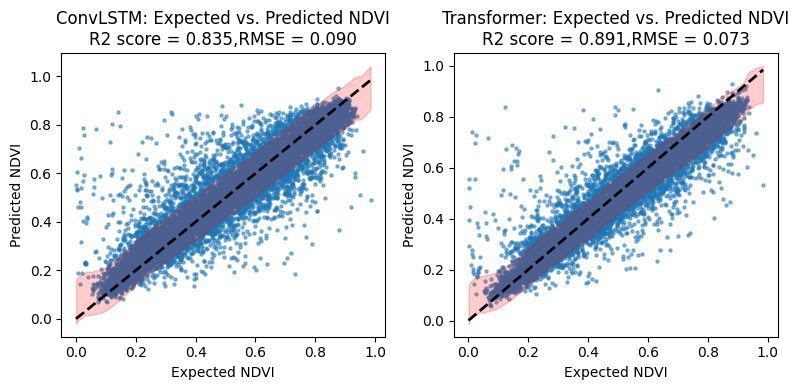

In [ ]:
# Mask the datasets to only include values in range [0, 1]
mask_convlstm = np.logical_and(inverse_convlstm_pred_test_df_c >= 0, inverse_convlstm_pred_test_df_c <= 1)
mask_transformer = np.logical_and(inverse_transformer_pred_test_df_c >= 0, inverse_transformer_pred_test_df_c <= 1)
mask_y_test = np.logical_and(inverse_y_test_df_c >= 0, inverse_y_test_df_c <= 1)

# Apply the masks
inverse_y_test_df_c_masked = inverse_y_test_df_c[mask_y_test]
inverse_convlstm_pred_test_df_c_masked = inverse_convlstm_pred_test_df_c[mask_convlstm]
inverse_transformer_pred_test_df_c_masked = inverse_transformer_pred_test_df_c[mask_transformer]

# Calculate R2 scores and RMSE
r2_convlstm_test_c = r2_score(inverse_y_test_df_c_masked, inverse_convlstm_pred_test_df_c_masked)
r2_transformer_test_c = r2_score(inverse_y_test_df_c_masked, inverse_transformer_pred_test_df_c_masked)

rmse_convlstm_test_c = np.sqrt(mean_squared_error(inverse_y_test_df_c_masked, inverse_convlstm_pred_test_df_c_masked))
rmse_transformer_test_c = np.sqrt(mean_squared_error(inverse_y_test_df_c_masked, inverse_transformer_pred_test_df_c_masked))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
titles = ['ConvLSTM', 'Transformer']
predictions = [inverse_convlstm_pred_test_df_c_masked, inverse_transformer_pred_test_df_c_masked]
r2_scores = [r2_convlstm_test_c, r2_transformer_test_c]
rmse_scores = [rmse_convlstm_test_c, rmse_transformer_test_c]

for idx, ax in enumerate(axes.flatten()):
    ax.scatter(inverse_y_test_df_c_masked.values.ravel(), predictions[idx].values.ravel(), s=5, alpha=0.5)
    min_val = np.min(inverse_y_test_df_c_masked.values.ravel())
    max_val = np.max(inverse_y_test_df_c_masked.values.ravel())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    deviation = np.std(inverse_y_test_df_c_masked.values.ravel() - predictions[idx].values.ravel())
    ax.fill_between(np.sort(inverse_y_test_df_c_masked.values.ravel()), 
                    np.sort(predictions[idx].values.ravel()) - deviation, 
                    np.sort(predictions[idx].values.ravel()) + deviation, 
                    alpha=0.2, color='r')
    ax.set_xlabel('Expected NDVI')
    ax.set_ylabel('Predicted NDVI')
    ax.set_title(f'{titles[idx]}: Expected vs. Predicted NDVI\nR2 score = {r2_scores[idx]:.3f},RMSE = {rmse_scores[idx]:.3f}')

plt.tight_layout()
plt.show()


**- MSE histogram**

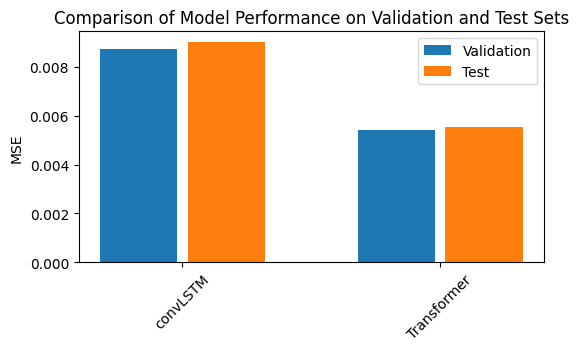

In [ ]:
# Compare the Mean Squared Error (MSE) for models

mse_convlstm_val_c = mean_squared_error(inverse_y_val, inverse_convlstm_pred_val)
mse_transformer_val_c = mean_squared_error(inverse_y_val, inverse_transformer_pred_val)

mse_convlstm_test_c = mean_squared_error(inverse_y_test, inverse_convlstm_pred_test)
mse_transformer_test_c = mean_squared_error(inverse_y_test, inverse_transformer_pred_test)

# Plot bar chart
plt.figure(figsize=(6, 3))
x = np.arange(2)
width = 0.3

plt.bar(x - 0.17, [mse_convlstm_val_c, mse_transformer_val_c], width, label='Validation')
plt.bar(x + 0.17, [mse_convlstm_test_c, mse_transformer_test_c], width, label='Test')
plt.xticks(ticks=x, labels=['convLSTM', 'Transformer'],
           rotation=45)
plt.ylabel('MSE')
plt.title('Comparison of Model Performance on Validation and Test Sets')
_ = plt.legend()
plt.show()

**- residual**

In [ ]:
#Comapre the residual
residuals_convlstm = inverse_y_test_df_c - inverse_convlstm_pred_test_df_c
residuals_transformer = inverse_y_test_df_c - inverse_transformer_pred_test_df_c

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Scatter plot for Random Forest residuals
ax1.scatter(inverse_y_test_df_c, residuals_convlstm, alpha=0.3)
ax1.set_xlabel('True NDVI')
ax1.set_ylabel('Residuals (Random Forest)')
ax1.hlines(0, min(inverse_y_test_df_c), max(inverse_y_test_df_c), color='red')  # Line at zero

# Scatter plot for LSTM residuals
ax2.scatter(inverse_y_test_df_c, residuals_transformer, alpha=0.3)
ax2.set_xlabel('True NDVI')
ax2.set_ylabel('Residuals (LSTM)')
ax2.hlines(0, min(inverse_y_test_df_c), max(inverse_y_test_df_c), color='red')  # Line at zero

plt.tight_layout()
plt.show()


**- Compare NDVI in timeseries**

In [ ]:
# Compareof True NDVI with RF and LSTM Predicted NDVI in timeseries

# Rename columns
inverse_y_test_df_c.columns = ['True NDVI']
inverse_convlstm_pred_test_df_c.columns = ['Predicted NDVI (ConvLSTM)']
inverse_transformer_pred_test_df_c.columns = ['Predicted NDVI (Transformer)']

# Merge dataframes into a single dataframe
merged_df = pd.concat([inverse_y_test_df_c, inverse_convlstm_pred_test_df_c, inverse_transformer_pred_test_df_c], axis=1)

# Merge dataframes into a single dataframe
merged_df = pd.concat([inverse_y_test_df_c, inverse_convlstm_pred_test_df_c, inverse_transformer_pred_test_df_c], axis=1)

In [ ]:
merged_df

,True NDVI,Predicted NDVI (ConvLSTM),Predicted NDVI (Transformer)
0,0.493113,0.424269,0.488242
1,0.491063,0.490364,0.486375
2,0.486552,0.496130,0.471929
3,0.482041,0.502968,0.467771
4,0.479990,0.491656,0.479407
...,...,...,...
10525,0.857303,0.865938,0.781554
10526,0.863545,0.854257,0.777398
10527,0.875138,0.853858,0.780462
10528,0.881380,0.864904,0.786725


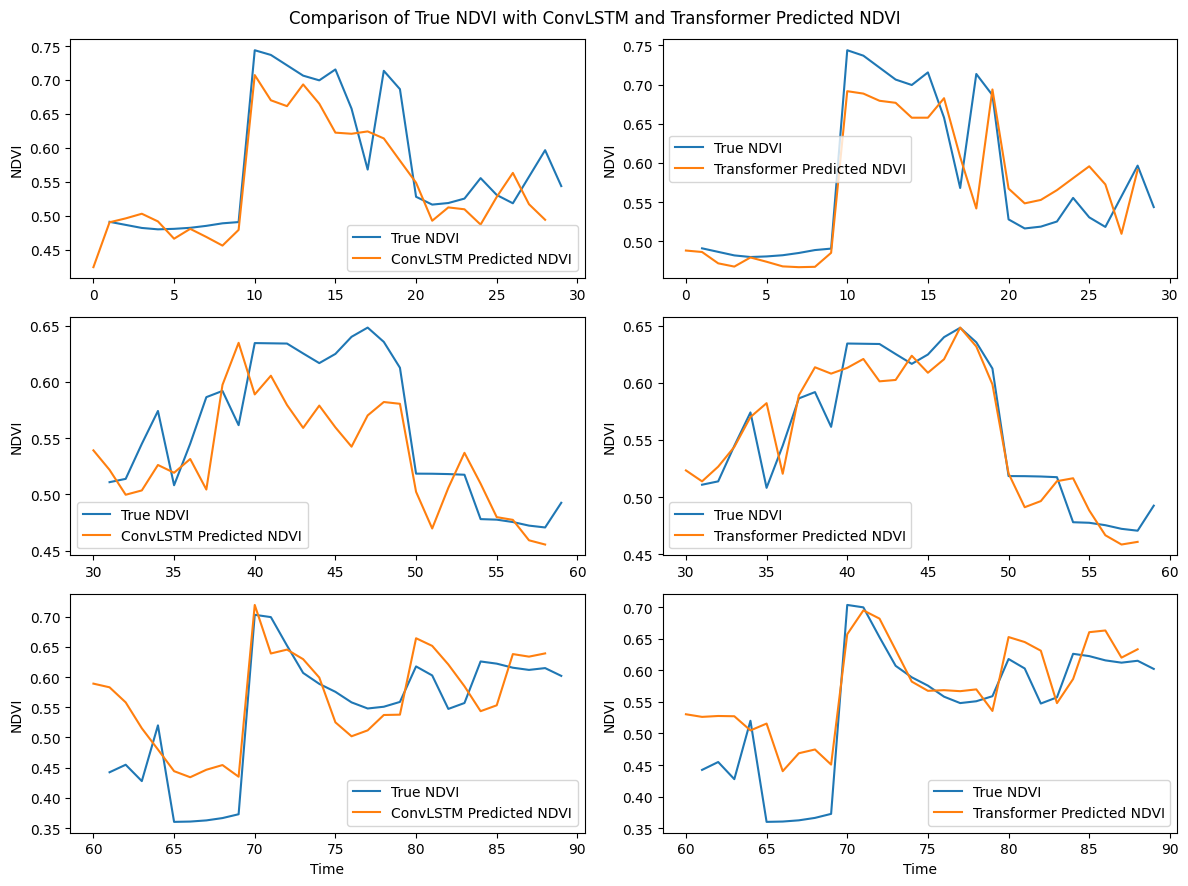

In [ ]:
import matplotlib.pyplot as plt

# Select the first 90 rows
df_subset = merged_df.iloc[:90]

# Create a figure with six subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 9))

# Loop over each pixel
for i in range(3):
    start = i * 30
    end = (i+1) * 30

    # Plot True NDVI and RF NDVI in the first subplot of each row
    axs[i, 0].plot(df_subset.index[start+1:end], df_subset['True NDVI'].values[start+1:end], label='True NDVI')
    axs[i, 0].plot(df_subset.index[start:end-1], df_subset['Predicted NDVI (ConvLSTM)'].values[start:end-1], label='ConvLSTM Predicted NDVI')
    axs[i, 0].set_ylabel('NDVI')
    axs[i, 0].legend()

    # Plot True NDVI and LSTM NDVI in the second subplot of each row
    axs[i, 1].plot(df_subset.index[start+1:end], df_subset['True NDVI'].values[start+1:end], label='True NDVI')
    axs[i, 1].plot(df_subset.index[start:end-1], df_subset['Predicted NDVI (Transformer)'].values[start:end-1], label='Transformer Predicted NDVI')
    axs[i, 1].set_ylabel('NDVI')
    axs[i, 1].legend()

# Add labels to the last row
axs[2, 0].set_xlabel('Time')
axs[2, 1].set_xlabel('Time')

# Add title to the figure
fig.suptitle('Comparison of True NDVI with ConvLSTM and Transformer Predicted NDVI')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## 3.2 Visualization for full image

In [ ]:
mse_convlstm_val = mean_squared_error(inverse_y_val, inverse_convlstm_pred_val)
mse_transformer_val = mean_squared_error(inverse_y_val, inverse_transformer_pred_val)

mse_convlstm_test = mean_squared_error(inverse_y_test, inverse_convlstm_pred_test)
mse_transformer_test = mean_squared_error(inverse_y_test, inverse_transformer_pred_test)

r2_convlstm_test = r2_score(inverse_y_test, inverse_convlstm_pred_test)
r2_transformer_test = r2_score(inverse_y_test, inverse_transformer_pred_test)

rmse_convlstm_test = np.sqrt(mean_squared_error(inverse_y_test, inverse_convlstm_pred_test))
rmse_transformer_test = np.sqrt(mean_squared_error(inverse_y_test, inverse_transformer_pred_test))


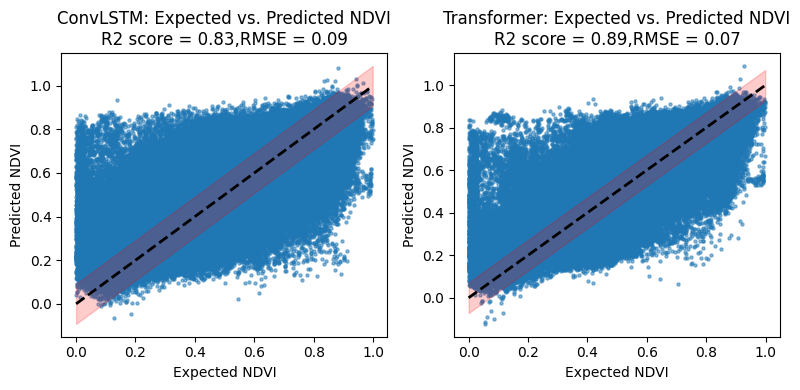

In [ ]:

# Create a 2x2 grid of subplots for the 4 different models
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Set titles and labels
titles = ['ConvLSTM', 'Transformer']
predictions = [inverse_convlstm_pred_test, inverse_transformer_pred_test]
r2_scores = [r2_convlstm_test, r2_transformer_test]
rmse_scores = [rmse_convlstm_test, rmse_transformer_test]

for idx, ax in enumerate(axes.flatten()):
    ax.scatter(inverse_y_test, predictions[idx], s=5, alpha=0.5)
    
    # One-to-one line
    min_val = np.min(inverse_y_test)
    max_val = np.max(inverse_y_test)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    
    # Deviation line
    deviation = np.std(inverse_y_test - predictions[idx])
    ax.fill_between(np.sort(inverse_y_test.flatten()), np.sort(inverse_y_test.flatten()) - deviation, np.sort(inverse_y_test.flatten()) + deviation, alpha=0.2, color='r')
    
    ax.set_xlabel('Expected NDVI')
    ax.set_ylabel('Predicted NDVI')
    ax.set_title(f'{titles[idx]}: Expected vs. Predicted NDVI\nR2 score = {r2_scores[idx]:.2f},RMSE = {rmse_scores[idx]:.2f}')

plt.tight_layout()
plt.show()

- MSE in **histogram**

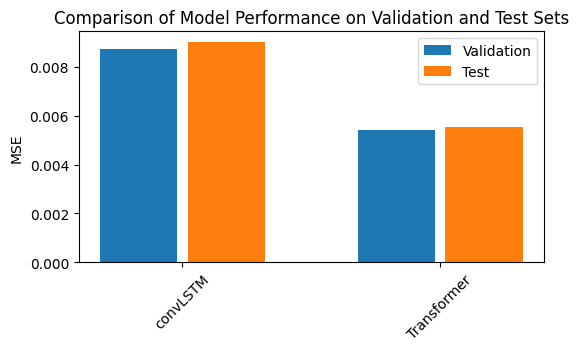

In [ ]:
# Compare the Mean Squared Error (MSE) for models

# Plot bar chart
plt.figure(figsize=(6, 3))
x = np.arange(2)
width = 0.3

plt.bar(x - 0.17, [mse_convlstm_val, mse_transformer_val], width, label='Validation')
plt.bar(x + 0.17, [mse_convlstm_test, mse_transformer_test], width, label='Test')
plt.xticks(ticks=x, labels=['convLSTM', 'Transformer'],
           rotation=45)
plt.ylabel('MSE')
plt.title('Comparison of Model Performance on Validation and Test Sets')
_ = plt.legend()
plt.show()



- NDVI **comaprasion**

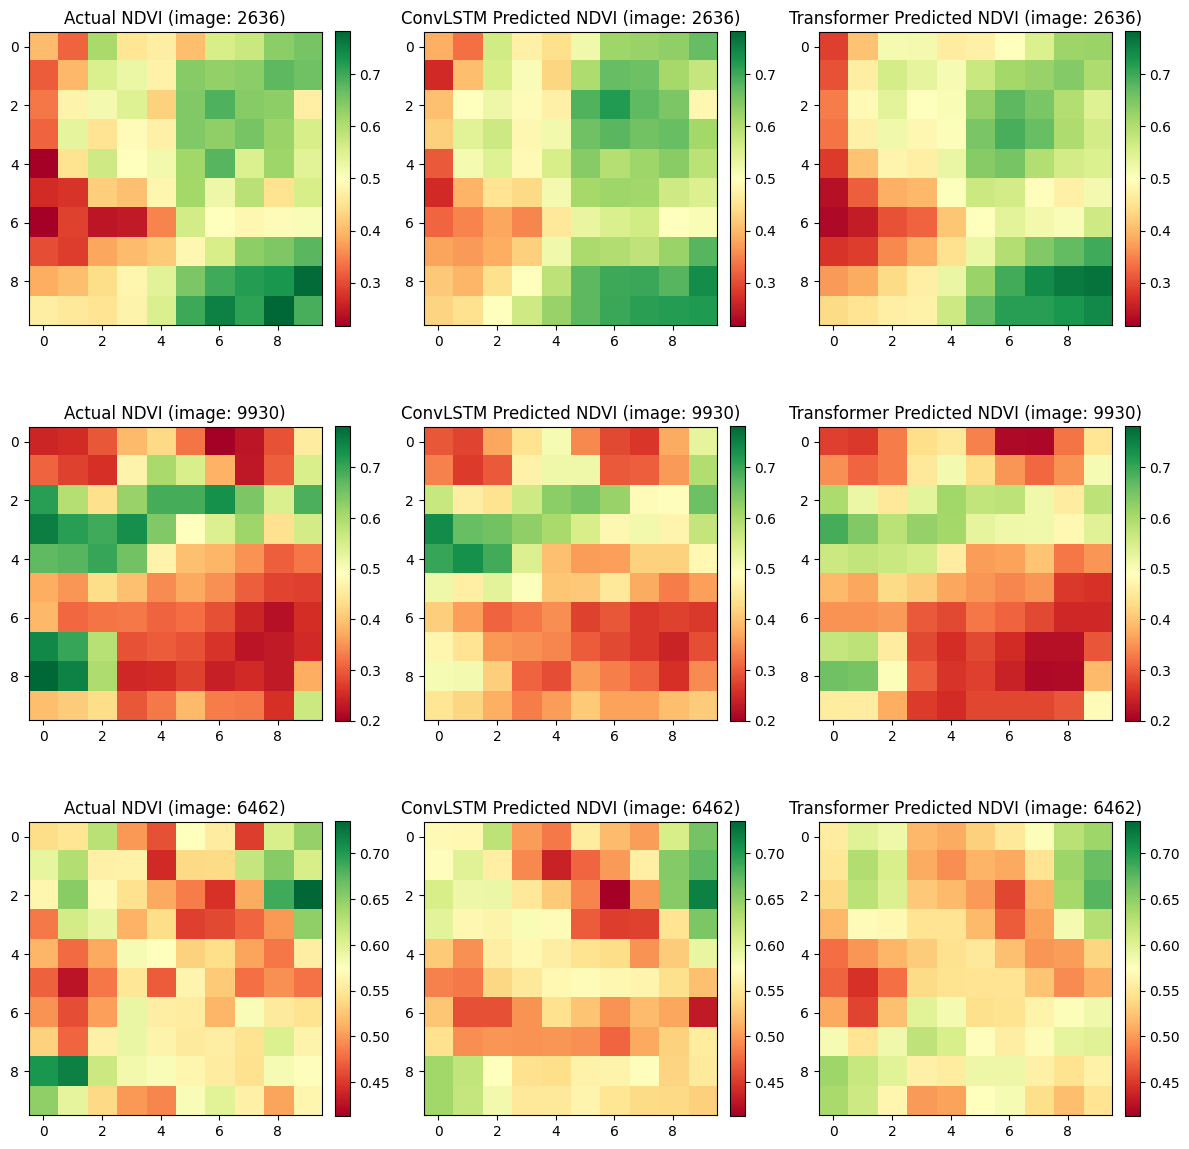

In [ ]:
import random
# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Randomly select three images (rows)
images = random.sample(range(len(inverse_y_test_df)), 3)

# For each image
for i, image in enumerate(images):
    # Select the image from each dataframe and reshape it
    image_y_test = inverse_y_test_df.iloc[image].values.reshape((10, 10))
    image_convlstm_pred_test = inverse_convlstm_pred_test_df.iloc[image].values.reshape((10, 10))
    image_transformer_pred_test = inverse_transformer_pred_test_df.iloc[image].values.reshape((10, 10))

    # Find min and max values for each image
    min_value = min(image_y_test.min(), image_convlstm_pred_test.min(), image_transformer_pred_test.min())
    max_value = max(image_y_test.max(), image_convlstm_pred_test.max(), image_transformer_pred_test.max())

    # Plot NDVI maps
    im1 = ax[i, 0].imshow(image_y_test, cmap='RdYlGn', vmin=min_value, vmax=max_value)
    ax[i, 0].set_title(f'Actual NDVI (image: {image})')
    fig.colorbar(im1, ax=ax[i, 0], fraction=0.046, pad=0.04)

    im2 = ax[i, 1].imshow(image_convlstm_pred_test, cmap='RdYlGn', vmin=min_value, vmax=max_value)
    ax[i, 1].set_title(f'ConvLSTM Predicted NDVI (image: {image})')
    fig.colorbar(im2, ax=ax[i, 1], fraction=0.046, pad=0.04)

    im3 = ax[i, 2].imshow(image_transformer_pred_test, cmap='RdYlGn', vmin=min_value, vmax=max_value)
    ax[i, 2].set_title(f'Transformer Predicted NDVI (image: {image})')
    fig.colorbar(im3, ax=ax[i, 2], fraction=0.046, pad=0.04)

# Display the plot
plt.tight_layout()
plt.show()



In [ ]:
y_test.shape

TensorShape([10530, 10, 10, 1])

In [ ]:
classes = [(0.015, 0.14), (0.14, 0.18), (0.18, 0.27), (0.27, 36),(0.36, 0.74)]

# Prepare an empty DataFrame to store the results
results = pd.DataFrame(columns=["NDVI Class", "Model", "MAE", "MSE", "RMSE"])

# Calculate MAE, MSE, and RMSE for each class
for i, (lower, upper) in enumerate(classes):
    # Create a mask for the current class based on actual NDVI values
    mask = (y_test > lower) & (y_test <= upper)

    # Apply mask
    class_y_test = y_test[mask]
    class_convlstm_pred_test = convlstm_pred_test[mask]
    class_transformer_pred_test = transformer_pred_test[mask]

    # Calculate and print metrics for the current class, if it is not empty
    if class_y_test.size > 0:
        # Calculate the metrics for ConvLSTM model
        metrics_convlstm = pd.DataFrame({
            "NDVI Class": [f"{lower}, {upper}"],
            "Model": ["ConvLSTM"],
            "MAE": [mean_absolute_error(class_y_test, class_convlstm_pred_test)],
            "MSE": [mean_squared_error(class_y_test, class_convlstm_pred_test)],
            "RMSE": [mean_squared_error(class_y_test, class_convlstm_pred_test, squared=False)]
        })
        results = pd.concat([results, metrics_convlstm])

        # Calculate the metrics for Transformer model
        metrics_transformer = pd.DataFrame({
            "NDVI Class": [f"{lower}, {upper}"],
            "Model": ["Transformer"],
            "MAE": [mean_absolute_error(class_y_test, class_transformer_pred_test)],
            "MSE": [mean_squared_error(class_y_test, class_transformer_pred_test)],
            "RMSE": [mean_squared_error(class_y_test, class_transformer_pred_test, squared=False)]
        })
        results = pd.concat([results, metrics_transformer])

# Reset the index
results = results.reset_index(drop=True)

# Print the results
print(results)
results.to_csv()

In [ ]:
convlstm_pred_test.shape

(10530, 100)


True NDVI Distribution:

                                  counts  proportions
Dense Vegetation\n(0.36-0.74)       5339     0.608017
Shrub and Grassland\n(0.18-0.27)    1298     0.147819
Sparse Vegetation\n(0.27-0.36)      1278     0.145542
Barren Land\n(0.14-0.18)             485     0.055233
Build-up\n(0.015-0.14)               381     0.043389


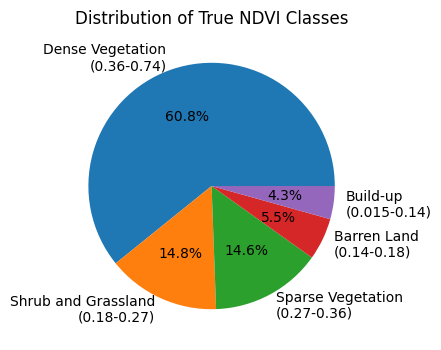


Predicted NDVI (ConvLSTM) Distribution:

                                  counts  proportions
Dense Vegetation\n(0.36-0.74)       5712     0.643243
Sparse Vegetation\n(0.27-0.36)      1442     0.162387
Shrub and Grassland\n(0.18-0.27)    1134     0.127703
Barren Land\n(0.14-0.18)             397     0.044707
Build-up\n(0.015-0.14)               195     0.021959


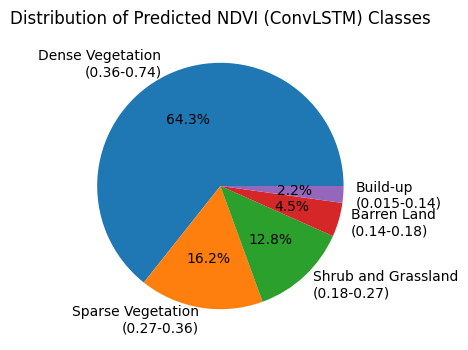


Predicted NDVI (Transformer) Distribution:

                                  counts  proportions
Dense Vegetation\n(0.36-0.74)       5845     0.630189
Sparse Vegetation\n(0.27-0.36)      1404     0.151375
Shrub and Grassland\n(0.18-0.27)    1254     0.135202
Barren Land\n(0.14-0.18)             530     0.057143
Build-up\n(0.015-0.14)               242     0.026092


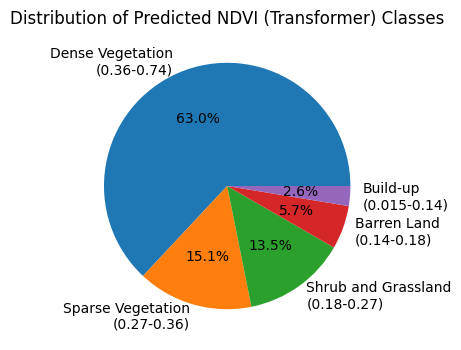

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Defining the class boundaries and labels
bounds = [0.015, 0.14, 0.18, 0.27, 0.36, 0.74]
labels = ["Build-up\n(0.015-0.14)", "Barren Land\n(0.14-0.18)", "Shrub and Grassland\n(0.18-0.27)", "Sparse Vegetation\n(0.27-0.36)", "Dense Vegetation\n(0.36-0.74)"]

# Create the class column for each series
merged_df['True NDVI class'] = pd.cut(merged_df['True NDVI'], bins=bounds, labels=labels)
merged_df['Predicted NDVI (ConvLSTM) class'] = pd.cut(merged_df['Predicted NDVI (ConvLSTM)'], bins=bounds, labels=labels)
merged_df['Predicted NDVI (Transformer) class'] = pd.cut(merged_df['Predicted NDVI (Transformer)'], bins=bounds, labels=labels)

# Prepare data for plot
series_names = ['True NDVI', 'Predicted NDVI (ConvLSTM)', 'Predicted NDVI (Transformer)']
distributions = {}

for name in series_names:
    class_name = name + ' class'
    counts = merged_df[class_name].value_counts()
    proportions = merged_df[class_name].value_counts(normalize=True)
    distributions[name] = pd.DataFrame({'counts': counts, 'proportions': proportions})

# Print distributions and plot pie charts
for name, distribution in distributions.items():
    print(f'\n{name} Distribution:\n')
    print(distribution)
    plt.figure(figsize=(5,4))
    plt.pie(distribution['proportions'], labels=distribution['proportions'].index, autopct='%1.1f%%')
    plt.title(f"Distribution of {name} Classes")
    plt.show()


In [ ]:
class_dict = {"0.015, 0.14": "Build-up", "0.14, 0.18": "Barren Land", "0.18, 0.27": "Shrub and Grassland", "0.27, 0.36": "Sparse Vegetation", "0.36, 0.74": "Dense Vegetation"}


    NDVI Class        Model       MAE       MSE      RMSE  Accuracy
0  0.015, 0.14     ConvLSTM  0.089919  0.023006  0.151676  0.761653
1  0.015, 0.14  Transformer  0.068082  0.015751  0.125502  0.856002
2   0.14, 0.18     ConvLSTM  0.056877  0.007813  0.088391  0.855720
3   0.14, 0.18  Transformer  0.039916  0.004899  0.069991  0.931053
4   0.18, 0.27     ConvLSTM  0.056753  0.007642  0.087418  0.849493
5   0.18, 0.27  Transformer  0.037308  0.003658  0.060481  0.932452
6     0.27, 36     ConvLSTM  0.062781  0.007739  0.087974  0.806873
7     0.27, 36  Transformer  0.048609  0.004789  0.069200  0.887735
8   0.36, 0.74     ConvLSTM  0.062944  0.007504  0.086628  0.803823
9   0.36, 0.74  Transformer  0.049894  0.004908  0.070060  0.879993


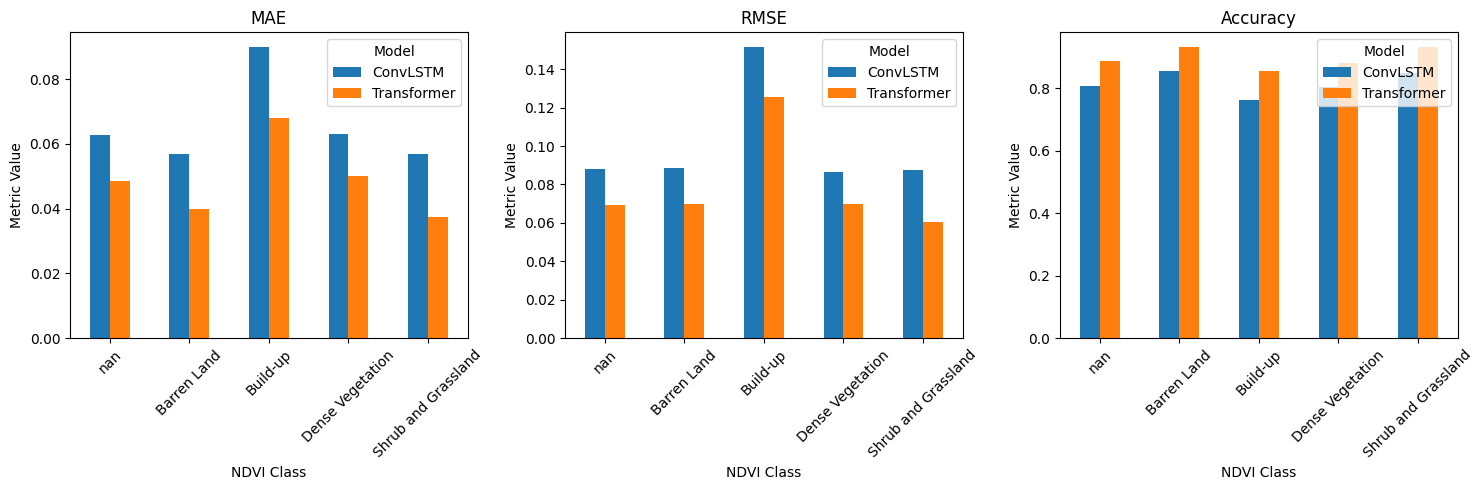

In [ ]:
# Prepare an empty DataFrame to store the results
results = pd.DataFrame(columns=["NDVI Class", "Model", "MAE", "MSE", "RMSE", "Accuracy"])

def calculate_accuracy(y_true, y_pred, tolerance=0.1):
    return np.mean(np.abs(y_true - y_pred) <= tolerance)


# Calculate MAE, MSE, RMSE, and Accuracy for each class
for i, (lower, upper) in enumerate(classes):
    # Create a mask for the current class based on actual NDVI values
    mask = (y_test_reshaped > lower) & (y_test_reshaped <= upper)

    # Apply mask
    class_y_test = y_test_reshaped[mask]
    class_convlstm_pred_test = convlstm_pred_test[mask]
    class_transformer_pred_test = transformer_pred_test[mask]

    # Calculate and print metrics for the current class, if it is not empty
    if class_y_test.size > 0:
        # Calculate the metrics for ConvLSTM model
        metrics_convlstm = pd.DataFrame({
            "NDVI Class": [f"{lower}, {upper}"],
            "Model": ["ConvLSTM"],
            "MAE": [mean_absolute_error(class_y_test, class_convlstm_pred_test)],
            "MSE": [mean_squared_error(class_y_test, class_convlstm_pred_test)],
            "RMSE": [mean_squared_error(class_y_test, class_convlstm_pred_test, squared=False)],
            "Accuracy": [calculate_accuracy(class_y_test, class_convlstm_pred_test)]  # calculate accuracy
        })
        results = pd.concat([results, metrics_convlstm])

        # Calculate the metrics for Transformer model
        metrics_transformer = pd.DataFrame({
            "NDVI Class": [f"{lower}, {upper}"],
            "Model": ["Transformer"],
            "MAE": [mean_absolute_error(class_y_test, class_transformer_pred_test)],
            "MSE": [mean_squared_error(class_y_test, class_transformer_pred_test)],
            "RMSE": [mean_squared_error(class_y_test, class_transformer_pred_test, squared=False)],
            "Accuracy": [calculate_accuracy(class_y_test, class_transformer_pred_test)]  # calculate accuracy
        })
        results = pd.concat([results, metrics_transformer])

# Reset the index
results = results.reset_index(drop=True)

# Print the results
print(results)

# Map the NDVI Class to the class names
results['NDVI Class'] = results['NDVI Class'].map(class_dict)

# Define the metrics
metrics = ['MAE', 'RMSE', 'Accuracy']

# Define the number of rows and columns for the subplot
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,5))

# For each metric, generate a bar plot
for i, metric in enumerate(metrics):
    metric_results = results.pivot(index='NDVI Class', columns='Model', values=metric)
    metric_results.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{metric}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Metric Value')

plt.tight_layout()
plt.show()


**- Difference images on NDVI**

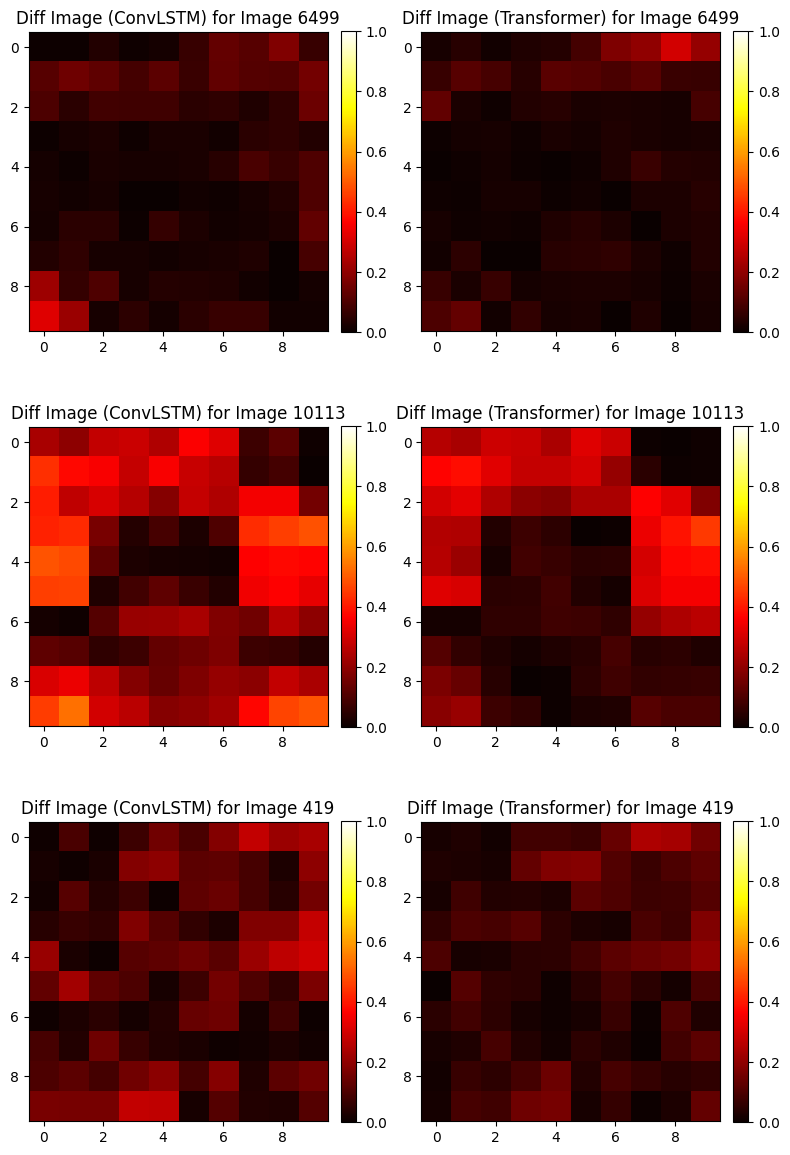

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Specify the indices of the images you want to visualize
np.random.seed(55)  # for reproducibility
image_indices = np.random.choice(inverse_y_test.shape[0], 3, replace=False) 


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

for i, image_index in enumerate(image_indices):
    # Reshape the 1D images back into 2D 10x10 images
    true_image = inverse_y_test[image_index].reshape((10, 10))  
    predicted_image_convlstm = inverse_convlstm_pred_test[image_index].reshape((10, 10))  
    predicted_image_transformer = inverse_transformer_pred_test[image_index].reshape((10, 10))  

    # Compute the difference images
    difference_image_convlstm = np.abs(true_image - predicted_image_convlstm)
    difference_image_transformer = np.abs(true_image - predicted_image_transformer)

    # Plot the difference images
    im1 = axes[i, 0].imshow(difference_image_convlstm, cmap='hot', vmin=0, vmax=1)
    axes[i, 0].set_title('Diff Image (ConvLSTM) for Image {}'.format(image_index))
    fig.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)
    
    im2 = axes[i, 1].imshow(difference_image_transformer, cmap='hot', vmin=0, vmax=1)
    axes[i, 1].set_title('Diff Image (Transformer) for Image {}'.format(image_index))
    fig.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# 4. View the single and multiple steps prediction performance

## 4.1 Single prediction step

In [ ]:
y_test_c.shape

(8030, 1)

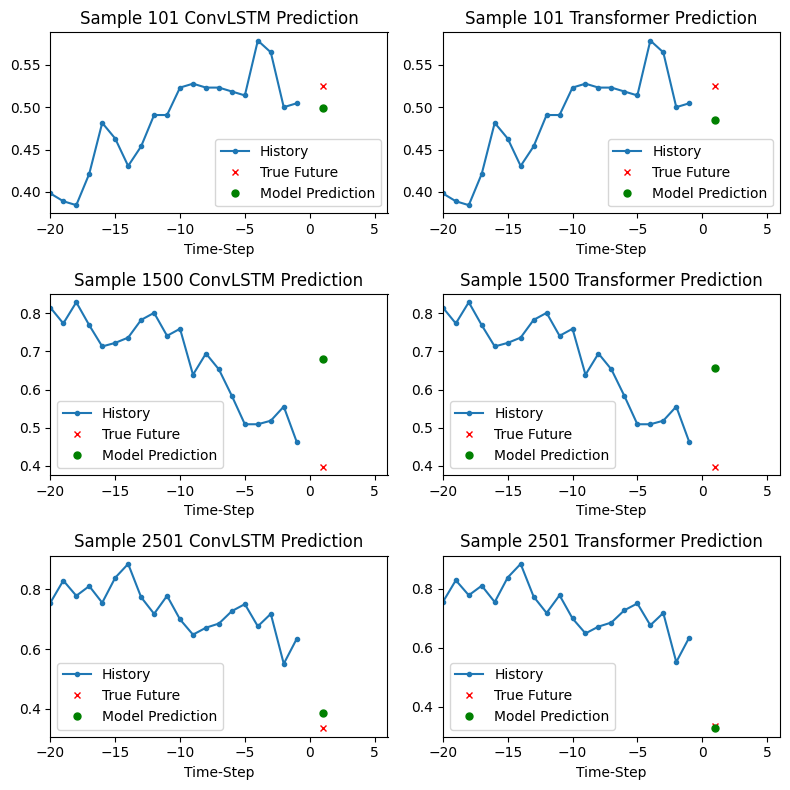

In [ ]:
import matplotlib.pyplot as plt

def show_plot(plot_data, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = 1

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], (future + 2) * 2])
    ax.set_xlabel("Time-Step")

# Prepare data for the plot
n = 3  # number of samples to visualize
specified_indices = [100, 1499, 2500]  # samples 1, 1000 and 3000

# Reshape y_test and X_test as specified
y_test_c = y_test_reshaped[:, 50].reshape(-1, 1)  # Select only the 50th value and reshape
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], -1, 4)

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(8, 8))  # adjust figsize as needed

for i, idx in enumerate(specified_indices):
    x_sample = X_test_reshaped[idx]
    y_sample = y_test_c[idx]
    history_ndvi = x_sample[:, 50, 0]  # Select only NDVI_scaled from input_vars

    # ConvLSTM
    y_pred_convlstm = convlstm_pred_test_df_c.iloc[idx, 0]
    ax = axes[i, 0]
    show_plot([history_ndvi, y_sample, y_pred_convlstm], f"Sample {idx + 1} ConvLSTM Prediction", ax)
    
    # Transformer
    y_pred_transformer = transformer_pred_test_df_c.iloc[idx, 0]
    ax = axes[i, 1]
    show_plot([history_ndvi, y_sample, y_pred_transformer], f"Sample {idx + 1} Transformer Prediction", ax)

plt.tight_layout()
plt.show()


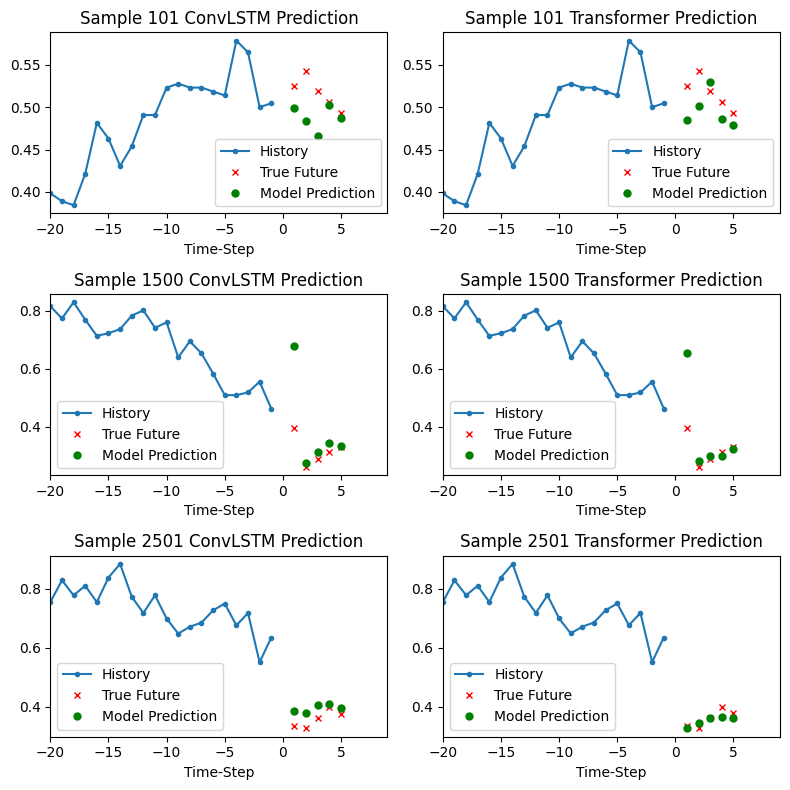

In [ ]:

def show_plot(plot_data, delta, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-plot_data[0].shape[0], 0))
    future = np.arange(1, 1 + len(plot_data[2]))

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i == 0:  # History
            ax.plot(time_steps, val.flatten(), marker[i], label=labels[i])
        elif i == 1:  # True Future
            ax.plot(future[:len(val)], val, marker[i], markersize=5, label=labels[i])
        elif i == 2:  # Model Prediction
            ax.plot(future, val, marker[i], markersize=5, label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], (delta - 1) + len(plot_data[2])])
    ax.set_xlabel("Time-Step")


# specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create figure and axes
fig, axes = plt.subplots(nrows=len(specified_indices), ncols=2, figsize=(8, 8))

# Number of future steps
n_steps = 5  

for i, idx in enumerate(specified_indices):
    # Select predictions
    preds_convlstm = convlstm_pred_test_df_c[idx: idx+n_steps]
    preds_transformer = transformer_pred_test_df_c[idx: idx+n_steps]

    # Select the next `n_steps` true future values for plotting
    #true_future = inverse_y_test_df_c[idx: idx+n_steps]
    true_future = y_test_c[idx: idx+n_steps]

    # Plot history, true future, and model predictions
    history_ndvi = X_test_reshaped[idx][:, 50, 0]  # Select only NDVI_scaled from input_vars
    show_plot([history_ndvi, true_future, preds_convlstm], n_steps, f"Sample {idx + 1} ConvLSTM Prediction", axes[i, 0])
    show_plot([history_ndvi, true_future, preds_transformer], n_steps, f"Sample {idx + 1} Transformer Prediction", axes[i, 1])
plt.tight_layout()
plt.show()


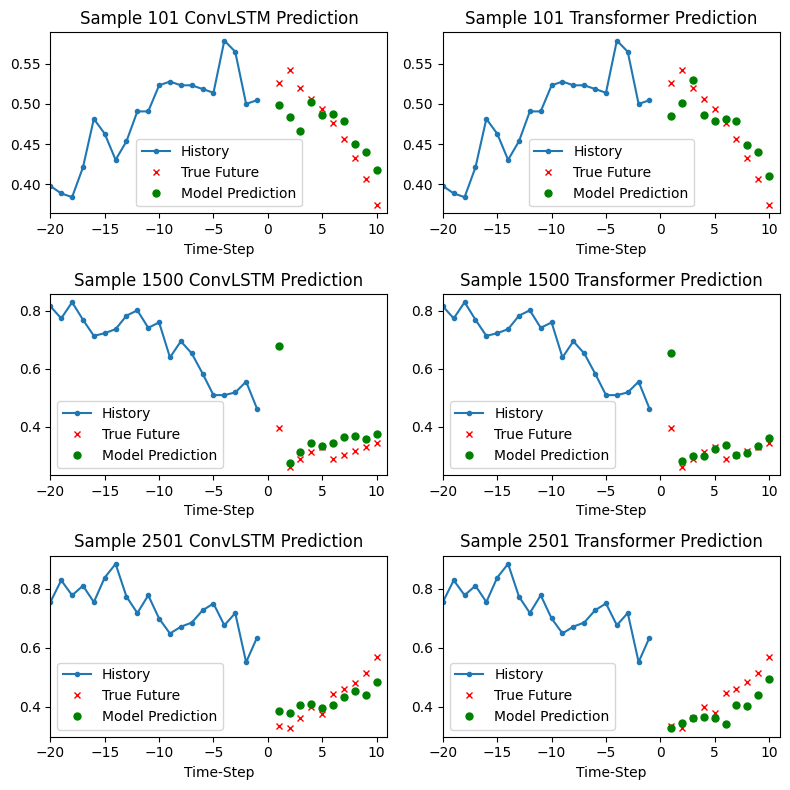

In [ ]:

def show_plot(plot_data, delta, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-plot_data[0].shape[0], 0))
    future = np.arange(1, 1 + len(plot_data[2]))

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i == 0:  # History
            ax.plot(time_steps, val.flatten(), marker[i], label=labels[i])
        elif i == 1:  # True Future
            ax.plot(future[:len(val)], val, marker[i], markersize=5, label=labels[i])
        elif i == 2:  # Model Prediction
            ax.plot(future, val, marker[i], markersize=5, label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], 1 + n_steps])
    ax.set_xlabel("Time-Step")


# specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create figure and axes
fig, axes = plt.subplots(nrows=len(specified_indices), ncols=2, figsize=(8, 8))

# Number of future steps
n_steps = 10  

for i, idx in enumerate(specified_indices):
    # Select predictions
    preds_convlstm = convlstm_pred_test_df_c[idx: idx+n_steps]
    preds_transformer = transformer_pred_test_df_c[idx: idx+n_steps]

    # Select the next `n_steps` true future values for plotting
    #true_future = inverse_y_test_df_c[idx: idx+n_steps]
    true_future = y_test_c[idx: idx+n_steps]

    # Plot history, true future, and model predictions
    history_ndvi = X_test_reshaped[idx][:, 50, 0]  # Select only NDVI_scaled from input_vars
    show_plot([history_ndvi, true_future, preds_convlstm], n_steps, f"Sample {idx + 1} ConvLSTM Prediction", axes[i, 0])
    show_plot([history_ndvi, true_future, preds_transformer], n_steps, f"Sample {idx + 1} Transformer Prediction", axes[i, 1])
plt.tight_layout()
plt.show()


In [ ]:
pip install numpy sklearn

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate the 10th prediction for each model
pred_10th_convlstm = convlstm_pred_test_df_c[9::n_steps]
pred_10th_transformer = transformer_pred_test_df_c[9::n_steps]

# Select the 10th true future value
true_10th_future = y_test_c[9::n_steps]

# Calculate MAE and RMSE for each model
mae_convlstm = mean_absolute_error(true_10th_future, pred_10th_convlstm)
rmse_convlstm = np.sqrt(mean_squared_error(true_10th_future, pred_10th_convlstm))

mae_transformer = mean_absolute_error(true_10th_future, pred_10th_transformer)
rmse_transformer = np.sqrt(mean_squared_error(true_10th_future, pred_10th_transformer))

print("ConvLSTM MAE: ", mae_convlstm)
print("ConvLSTM RMSE: ", rmse_convlstm)
print("Transformer MAE: ", mae_transformer)
print("Transformer RMSE: ", rmse_transformer)


ConvLSTM MAE:  0.07857009
ConvLSTM RMSE:  0.11373873
Transformer MAE:  0.06286729
Transformer RMSE:  0.0905626


MAE for each time step:
   ConvLSTM MAE  Transformer MAE
0      0.058059         0.048072
1      0.059065         0.047595
2      0.057951         0.047641
3      0.055477         0.047051
4      0.055523         0.044322
5      0.053627         0.045369
6      0.055069         0.044461
7      0.058176         0.047873
8      0.063315         0.048078
9      0.078570         0.062867

RMSE for each time step:
   ConvLSTM RMSE  Transformer RMSE
0       0.083851          0.071450
1       0.087380          0.072901
2       0.089743          0.075944
3       0.082619          0.069317
4       0.083208          0.063714
5       0.079968          0.068909
6       0.078146          0.065398
7       0.090116          0.075054
8       0.096864          0.072114
9       0.113739          0.090563


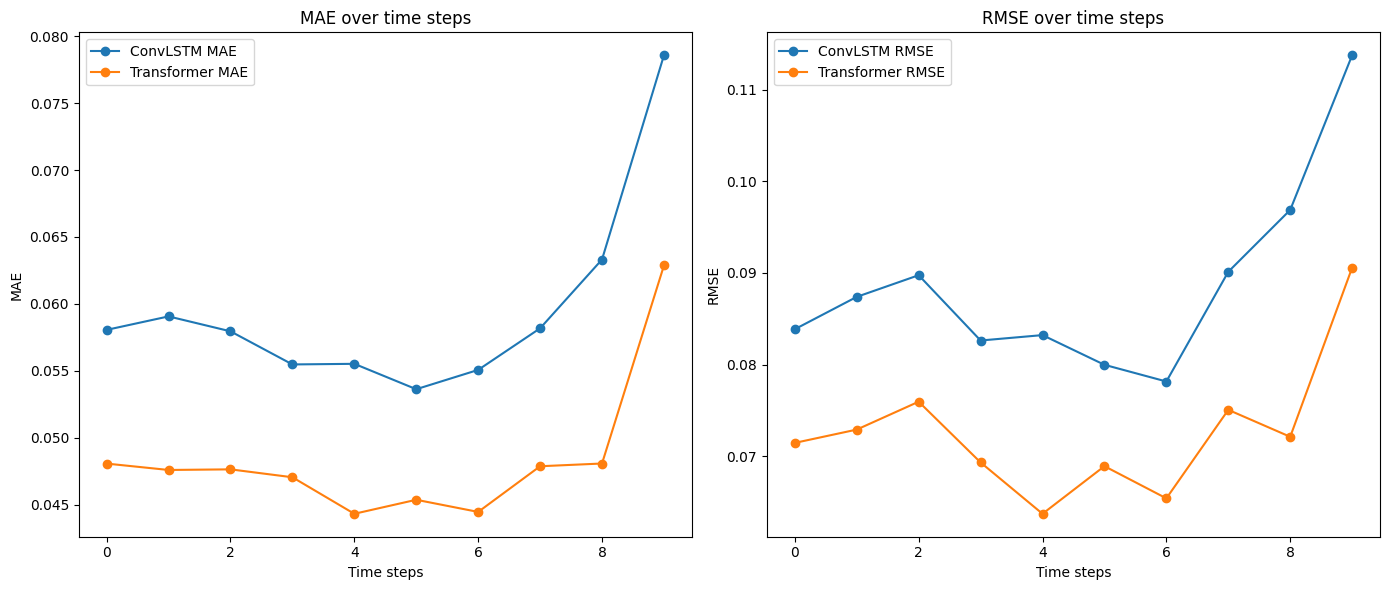

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initiate empty lists to store MAE and RMSE for each time step
mae_convlstm = []
rmse_convlstm = []
mae_transformer = []
rmse_transformer = []

# Calculate the prediction for each time step
for i in range(n_steps):
    pred_convlstm = convlstm_pred_test_df_c[i::n_steps]
    pred_transformer = transformer_pred_test_df_c[i::n_steps]
    
    # Select the true future value for each time step
    true_future = y_test_c[i::n_steps]
    
    # Calculate MAE and RMSE for each time step and append to list
    mae_convlstm.append(mean_absolute_error(true_future, pred_convlstm))
    rmse_convlstm.append(np.sqrt(mean_squared_error(true_future, pred_convlstm)))
    mae_transformer.append(mean_absolute_error(true_future, pred_transformer))
    rmse_transformer.append(np.sqrt(mean_squared_error(true_future, pred_transformer)))

# Create dataframes for the results
df_mae = pd.DataFrame({"ConvLSTM MAE": mae_convlstm, "Transformer MAE": mae_transformer})
df_rmse = pd.DataFrame({"ConvLSTM RMSE": rmse_convlstm, "Transformer RMSE": rmse_transformer})

# Display the results in table
print("MAE for each time step:")
print(df_mae)
print("\nRMSE for each time step:")
print(df_rmse)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df_mae.plot(ax=axes[0],marker='o')
axes[0].set_title('MAE over time steps')
axes[0].set_xlabel('Time steps')
axes[0].set_ylabel('MAE')

df_rmse.plot(ax=axes[1],marker='o')
axes[1].set_title('RMSE over time steps')
axes[1].set_xlabel('Time steps')
axes[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


In [ ]:
y_sample

array([0.24206947, 0.50638217, 0.5813048 , 0.62705535, 0.6617889 ],
      dtype=float32)

## 4.3 View the prediction ability of models on different prediction timesteps

In [ ]:
X_test_reshaped[idx][:, 50, 0].shape

(20,)

In [ ]:
convlstm_predictions[i, j].shape

()

In [ ]:
x_sample_convlstm.shape

(20,)

In [ ]:
from sklearn.metrics import r2_score

# Limiting the test set size to 1000
X_test = X_test[:1000]
y_test = y_test_reshaped[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
convlstm_predictions = np.zeros((n_samples, n_steps))
transformer_predictions = np.zeros((n_samples, n_steps))
y_samples = np.zeros((n_samples, n_steps))

# Number of future steps
n_steps = 1

# Generate predictions for each sample in the test set
for i in range(n_samples):
    x_sample_convlstm = X_test[i][np.newaxis, :, :, :, :]
    x_sample_transformer = X_test[i][np.newaxis, :, :, :, :]

    y_sample = y_test[i : i + n_steps, 50]

    for j in range(n_steps):
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm) [0] #[0, 5, 1, 0]
        
        # Flatten the array
        y_pred_convlstm_flat = np.reshape(y_pred_convlstm, (100, 1))

        # Select the 50th value
        y_pred_convlstm = y_pred_convlstm_flat[50]

        y_pred_transformer = transformer_model.predict(x_sample_transformer)[0]
        # Flatten the array
        y_pred_transformer_flat = np.reshape(y_pred_transformer, (100, 1))

        # Select the 50th value
        y_pred_transformer = y_pred_transformer_flat[50]

        # Add the prediction to the list
        convlstm_predictions[i, j] = y_pred_convlstm
        transformer_predictions[i, j] = y_pred_transformer

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        
        x_sample_convlstm[0, -1, 5, 1, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 5, 1, 0] = y_pred_transformer  # Update the last value with the new prediction

    y_samples[i, :] = y_sample.flatten()

# Compute and print R2 score for each model at each timestep
for timestep in range(n_steps):
    r2_convlstm = r2_score(y_samples[:, timestep], convlstm_predictions[:, timestep])
    r2_transformer = r2_score(y_samples[:, timestep], transformer_predictions[:, timestep])

    print(f"R2 score at timestep {timestep+1} - ConvLSTM: {r2_convlstm}, Transformer: {r2_transformer}")


In [ ]:
from sklearn.metrics import r2_score

# Limiting the test set size to 1000
X_test = X_test[:1000]
y_test = y_test[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
convlstm_predictions = np.zeros((n_samples, n_steps))
transformer_predictions = np.zeros((n_samples, n_steps))
y_samples = np.zeros((n_samples, n_steps))

# Number of future steps
n_steps = 5

# Generate predictions for each sample in the test set
for i in range(n_samples):
    x_sample_convlstm = X_test[i][np.newaxis, :, :, :, :]
    x_sample_transformer = X_test[i][np.newaxis, :, :, :, :]

    y_sample = y_test_reshaped[i : i + n_steps, 50]

    for j in range(n_steps):
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm) [0] #[0, 5, 1, 0]
        
        # Flatten the array
        y_pred_convlstm_flat = np.reshape(y_pred_convlstm, (100, 1))

        # Select the 50th value
        y_pred_convlstm = y_pred_convlstm_flat[50]

        y_pred_transformer = transformer_model.predict(x_sample_transformer)[0]
        # Flatten the array
        y_pred_transformer_flat = np.reshape(y_pred_transformer, (100, 1))

        # Select the 50th value
        y_pred_transformer = y_pred_transformer_flat[50]

        # Add the prediction to the list
        convlstm_predictions[i, j] = y_pred_convlstm
        transformer_predictions[i, j] = y_pred_transformer

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        
        x_sample_convlstm[0, -1, 5, 1, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 5, 1, 0] = y_pred_transformer  # Update the last value with the new prediction

    y_samples[i, :] = y_sample.flatten()

# Compute and print R2 score for each model at each timestep
for timestep in range(n_steps):
    r2_convlstm = r2_score(y_samples[:, timestep], convlstm_predictions[:, timestep])
    r2_transformer = r2_score(y_samples[:, timestep], transformer_predictions[:, timestep])

    print(f"R2 score at timestep {timestep+1} - ConvLSTM: {r2_convlstm}, Transformer: {r2_transformer}")


In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
y_test = y_test_reshaped[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
convlstm_predictions = np.zeros((n_samples, n_steps))
transformer_predictions = np.zeros((n_samples, n_steps))
y_samples = np.zeros((n_samples, n_steps))

# Number of future steps
n_steps = 10

# Generate predictions for each sample in the test set
for i in range(n_samples):
    x_sample_convlstm = X_test[i][np.newaxis, :, :, :, :]
    x_sample_transformer = X_test[i][np.newaxis, :, :, :, :]

    y_sample = y_test[i : i + n_steps, 50]

    for j in range(n_steps):
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm) [0] #[0, 5, 1, 0]
        
        # Flatten the array
        y_pred_convlstm_flat = np.reshape(y_pred_convlstm, (100, 1))

        # Select the 50th value
        y_pred_convlstm = y_pred_convlstm_flat[50]

        y_pred_transformer = transformer_model.predict(x_sample_transformer)[0]
        # Flatten the array
        y_pred_transformer_flat = np.reshape(y_pred_transformer, (100, 1))

        # Select the 50th value
        y_pred_transformer = y_pred_transformer_flat[50]

        # Add the prediction to the list
        convlstm_predictions[i, j] = y_pred_convlstm
        transformer_predictions[i, j] = y_pred_transformer

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        
        x_sample_convlstm[0, -1, 5, 1, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 5, 1, 0] = y_pred_transformer  # Update the last value with the new prediction

    y_samples[i, :] = y_sample.flatten()


In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
y_test = y_test_reshaped[:1000]

# Number of future steps
n_steps = 10

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
convlstm_predictions = np.zeros((n_samples, n_steps))
transformer_predictions = np.zeros((n_samples, n_steps))
y_samples = np.zeros((n_samples, n_steps))



# Generate predictions for each sample in the test set
from tqdm import tqdm  # for the progress bar
for i in tqdm(range(n_samples - n_steps)):
    x_sample_convlstm = X_test[i][np.newaxis, :, :, :, :]
    x_sample_transformer = X_test[i][np.newaxis, :, :, :, :]

    for j in range(n_steps):
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm) [0] #[0, 5, 1, 0]
        
        # Flatten the array
        y_pred_convlstm_flat = np.reshape(y_pred_convlstm, (100, 1))

        # Select the 50th value
        y_pred_convlstm = y_pred_convlstm_flat[50]

        y_pred_transformer = transformer_model.predict(x_sample_transformer)[0]
        # Flatten the array
        y_pred_transformer_flat = np.reshape(y_pred_transformer, (100, 1))

        # Select the 50th value
        y_pred_transformer = y_pred_transformer_flat[50]

        # Add the prediction to the list
        convlstm_predictions[i, j] = y_pred_convlstm
        transformer_predictions[i, j] = y_pred_transformer

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 5, 1, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 5, 1, 0] = y_pred_transformer  # Update the last value with the new prediction

        # Add the true future values at the corresponding timesteps to the array
        y_samples[i, :] = y_test[i : i + n_steps, 50]


In [ ]:
X_test.shape;
y_test_reshaped.shape

(10530, 100)

In [ ]:
y_samples.shape


(1000, 10)

In [ ]:
np.save('y_samples_multi.npy', y_samples)
np.save('convlstm_predictions.npy', convlstm_predictions)
np.save('transformer_predictions.npy', transformer_predictions)

In [ ]:
y_samples_avg = np.load('/content/drive/MyDrive/y_samples_avg.npy')
y_samples_multi = np.load('/content/drive/MyDrive/y_samples_multi.npy')
rf_predictions = np.load('/content/drive/MyDrive/rf_predictions.npy')
lstm_predictions = np.load('/content/drive/MyDrive/lstm_predictions.npy')
convlstm_predictions = np.load('/content/drive/MyDrive/convlstm_predictions.npy')
transformer_predictions = np.load('/content/drive/MyDrive/transformer_predictions.npy')

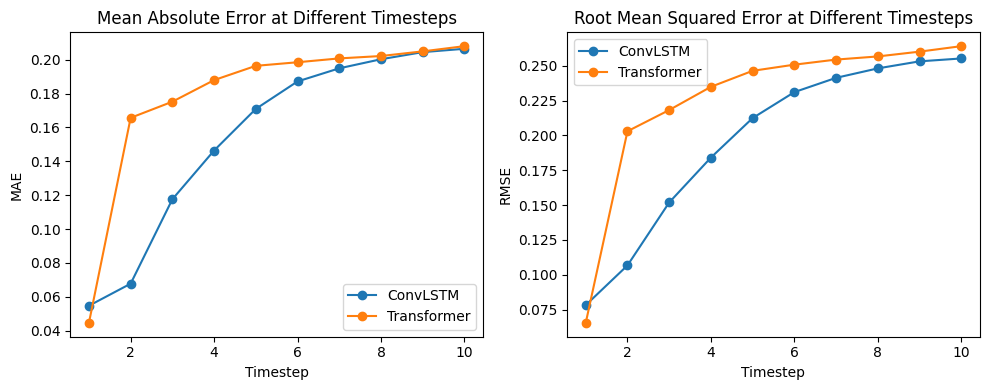

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Store the metric values for each model
mae_values_convlstm = []
rmse_values_convlstm = []
mae_values_transformer = []
rmse_values_transformer = []

# Select the specific timestep values
for step in range(n_steps):  # Iterate over 10 timesteps
    y_samples_timestep = y_samples[:, step]
    convlstm_predictions_timestep = convlstm_predictions[:, step]
    transformer_predictions_timestep = transformer_predictions[:, step]

    # Compute the metrics for ConvLSTM model
    mae_convlstm = mean_absolute_error(y_samples_timestep, convlstm_predictions_timestep)
    rmse_convlstm = sqrt(mean_squared_error(y_samples_timestep, convlstm_predictions_timestep))
    
    # Compute the metrics for Transformer model
    mae_transformer = mean_absolute_error(y_samples_timestep, transformer_predictions_timestep)
    rmse_transformer = sqrt(mean_squared_error(y_samples_timestep, transformer_predictions_timestep))

    # Append the calculated metric values to the lists
    mae_values_convlstm.append(mae_convlstm)
    rmse_values_convlstm.append(rmse_convlstm)
    mae_values_transformer.append(mae_transformer)
    rmse_values_transformer.append(rmse_transformer)

    # Indices for X-axis for the plot
indices = np.arange(1, 11)  # 1 to 10 timesteps

# Creating a figure with two subplots - one for MAE and another for RMSE
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the MAE values
ax[0].plot(indices, mae_values_convlstm, marker='o', linestyle='-', label='ConvLSTM')
ax[0].plot(indices, mae_values_transformer, marker='o', linestyle='-', label='Transformer')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Timestep')
ax[0].set_title('Mean Absolute Error at Different Timesteps')
ax[0].legend()

# Plotting the RMSE values
ax[1].plot(indices, rmse_values_convlstm, marker='o', linestyle='-', label='ConvLSTM')
ax[1].plot(indices, rmse_values_transformer, marker='o', linestyle='-', label='Transformer')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('Timestep')
ax[1].set_title('Root Mean Squared Error at Different Timesteps')
ax[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
convlstm_predictions.shape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# Store the metric values for each model
mae_values_rf = []
rmse_values_rf = []
mae_values_lstm = []
rmse_values_lstm = []
mae_values_convlstm = []
rmse_values_convlstm = []
mae_values_transformer = []
rmse_values_transformer = []

# Compute metrics for each timestep
for step in range(10):  # For each of the 10 timesteps
    # Compute the metrics for RF model
    mae_rf = mean_absolute_error(y_samples_avg[:, step], rf_predictions[:, step])
    rmse_rf = sqrt(mean_squared_error(y_samples_avg[:, step], rf_predictions[:, step]))
    
    # Compute the metrics for LSTM model
    mae_lstm = mean_absolute_error(y_samples_avg[:, step], lstm_predictions[:, step])
    rmse_lstm = sqrt(mean_squared_error(y_samples_avg[:, step], lstm_predictions[:, step]))

    # Compute the metrics for ConvLSTM model
    mae_convlstm = mean_absolute_error(y_samples_multi[:, step], convlstm_predictions[:, step])
    rmse_convlstm = sqrt(mean_squared_error(y_samples_multi[:, step], convlstm_predictions[:, step]))
    
    # Compute the metrics for Transformer model
    mae_transformer = mean_absolute_error(y_samples_multi[:, step], transformer_predictions[:, step])
    rmse_transformer = sqrt(mean_squared_error(y_samples_multi[:, step], transformer_predictions[:, step]))

    # Append the calculated metric values to the lists
    mae_values_rf.append(mae_rf)
    rmse_values_rf.append(rmse_rf)
    mae_values_lstm.append(mae_lstm)
    rmse_values_lstm.append(rmse_lstm)
    mae_values_convlstm.append(mae_convlstm)
    rmse_values_convlstm.append(rmse_convlstm)
    mae_values_transformer.append(mae_transformer)
    rmse_values_transformer.append(rmse_transformer)

# Create the X values (1 to 10)
x_values = np.arange(1, 11)

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the MAE values
ax[0].plot(x_values, mae_values_rf, marker='o', label='RF')
ax[0].plot(x_values, mae_values_lstm, marker='o', label='LSTM')
ax[0].plot(x_values, mae_values_convlstm, marker='o', label='ConvLSTM')
ax[0].plot(x_values, mae_values_transformer, marker='o', label='Transformer')
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('MAE')
ax[0].set_title('Mean Absolute Error at Each Timestep')
ax[0].legend()

# Plot the RMSE values
ax[1].plot(x_values, rmse_values_rf, marker='o', label='RF')
ax[1].plot(x_values, rmse_values_lstm, marker='o', label='LSTM')
ax[1].plot(x_values, rmse_values_convlstm, marker='o', label='ConvLSTM')
ax[1].plot(x_values, rmse_values_transformer, marker='o', label='Transformer')
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Root Mean Squared Error at Each Timestep')
ax[1].legend()

plt.show()


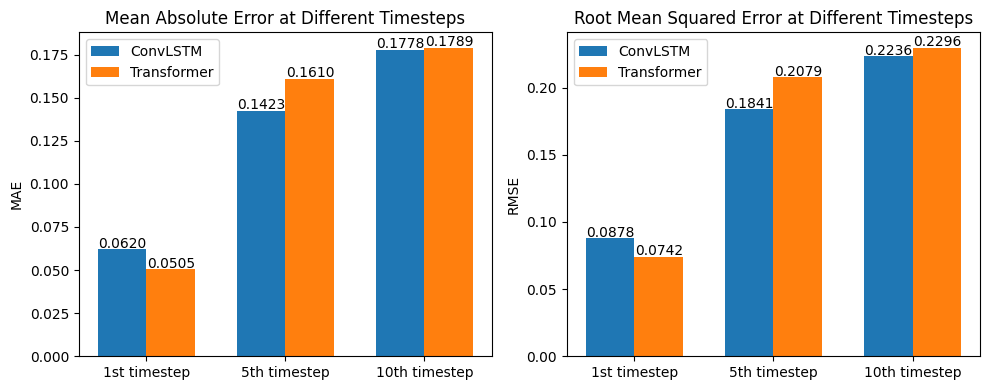

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# Store the metric values for each model
mae_values_convlstm = []
rmse_values_convlstm = []
mae_values_transformer = []
rmse_values_transformer = []

# Select the specific timestep values
for step in [0, 4, 9]:  # 1st, 5th and 10th timestep
    y_samples_timestep = y_samples[:, step]
    convlstm_predictions_timestep = convlstm_predictions[:, step]
    transformer_predictions_timestep = transformer_predictions[:, step]

    # Compute the metrics for ConvLSTM model
    mae_convlstm = mean_absolute_error(y_samples_timestep, convlstm_predictions_timestep)
    rmse_convlstm = sqrt(mean_squared_error(y_samples_timestep, convlstm_predictions_timestep))
    
    # Compute the metrics for Transformer model
    mae_transformer = mean_absolute_error(y_samples_timestep, transformer_predictions_timestep)
    rmse_transformer = sqrt(mean_squared_error(y_samples_timestep, transformer_predictions_timestep))

    # Append the calculated metric values to the lists
    mae_values_convlstm.append(mae_convlstm)
    rmse_values_convlstm.append(rmse_convlstm)
    mae_values_transformer.append(mae_transformer)
    rmse_values_transformer.append(rmse_transformer)

# Indices for X-axis for the plot
indices = np.arange(3)

# Width of a bar in the bar plot
width = 0.35

# Creating a figure with two subplots - one for MAE and another for RMSE
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the MAE values
ax[0].bar(indices, mae_values_convlstm, width, label='ConvLSTM')
ax[0].bar(indices + width, mae_values_transformer, width, label='Transformer')
ax[0].set_ylabel('MAE')
ax[0].set_title('Mean Absolute Error at Different Timesteps')
ax[0].set_xticks(indices + width / 2)
ax[0].set_xticklabels(['1st timestep', '5th timestep', '10th timestep'])
ax[0].legend()

# Display the MAE values above each bar
for i, v in enumerate(mae_values_convlstm):
    ax[0].text(i - 0.17, v + 0.001, f"{v:.4f}")
for i, v in enumerate(mae_values_transformer):
    ax[0].text(i + 0.18, v + 0.001, f"{v:.4f}")

# Plotting the RMSE values
ax[1].bar(indices, rmse_values_convlstm, width, label='ConvLSTM')
ax[1].bar(indices + width, rmse_values_transformer, width, label='Transformer')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Root Mean Squared Error at Different Timesteps')
ax[1].set_xticks(indices + width / 2)
ax[1].set_xticklabels(['1st timestep', '5th timestep', '10th timestep'])
ax[1].legend()

# Display the RMSE values above each bar
for i, v in enumerate(rmse_values_convlstm):
    ax[1].text(i - 0.17, v + 0.001, f"{v:.4f}")
for i, v in enumerate(rmse_values_transformer):
    ax[1].text(i + 0.18, v + 0.001, f"{v:.4f}")

# Display the plots
plt.tight_layout()
plt.show()
